In [ ]:
 !pip install yfinance ta xgboost --quiet

  Preparing metadata (setup.py) ... done



================= MEMPROSES SONY =================
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MAE   : 0.0586
MSE   : 0.0199
RMSE  : 0.1411
R²    : 0.9151
Tanggal penutupan terakhir: 2025-04-24
Harga penutupan terakhir  : 25.12
Prediksi penutupan        : 24.98 (untuk tanggal 2025-04-25)

📈 Evaluasi Real (Auto Yahoo Finance):
Harga aktual         : 24.97
Selisih prediksi     : 0.01
MAPE terhadap aktual : 0.03%
Akurasi prediksi     : 99.97%



Prediksi 7 hari ke depan:
Prediksi untuk tanggal 2025-04-28 : 24.98
Prediksi untuk tanggal 2025-04-29 : 24.83
Prediksi untuk tanggal 2025-04-30 : 24.69
Prediksi untuk tanggal 2025-05-01 : 24.54
Prediksi untuk tanggal 2025-05-02 : 24.39
Prediksi untuk tanggal 2025-05-05 : 24.25
Prediksi untuk tanggal 2025-05-06 : 24.10


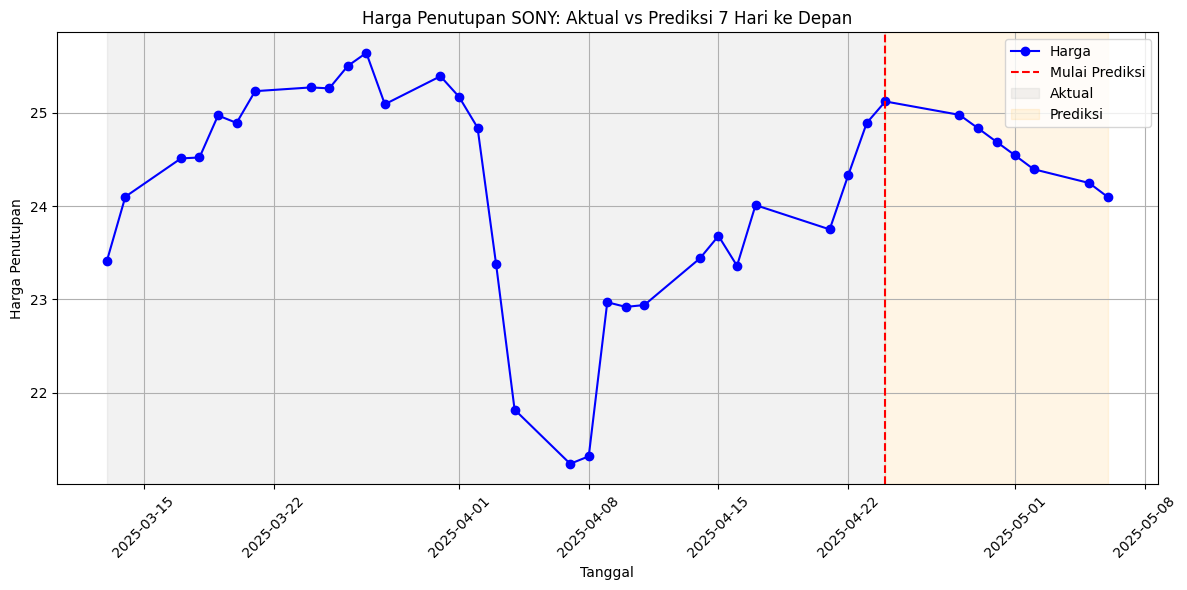

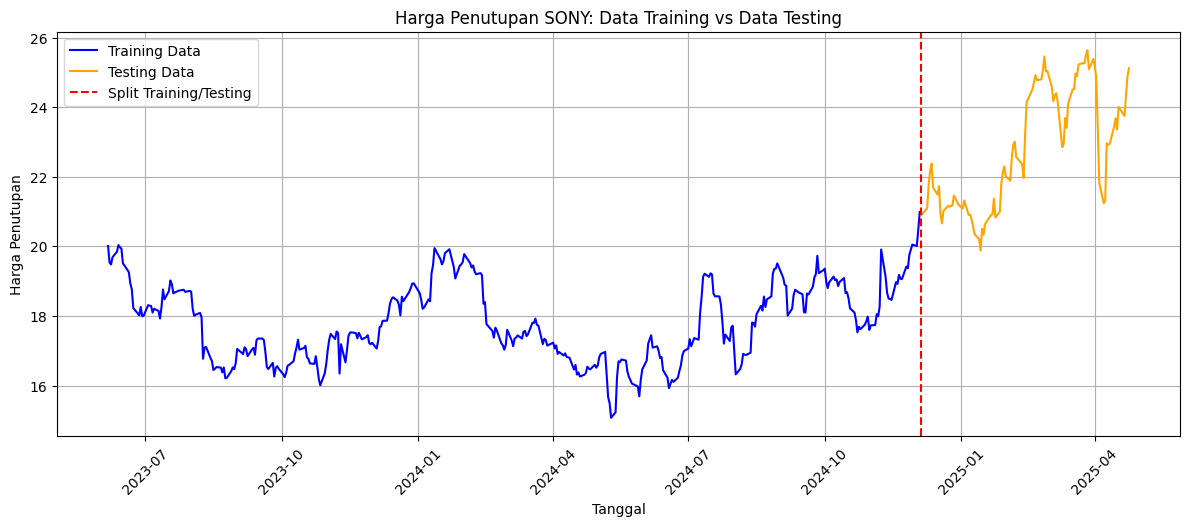

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Semua hasil prediksi disimpan ke: prediksi_7hari.csv

================= MEMPROSES 1810.HK =================



[*********************100%***********************]  1 of 1 completed


MAE   : 0.5441
MSE   : 1.3381
RMSE  : 1.1568
R²    : 0.6081
Tanggal penutupan terakhir: 2025-04-24
Harga penutupan terakhir  : 48.20
Prediksi penutupan        : 47.73 (untuk tanggal 2025-04-25)

📈 Evaluasi Real (Auto Yahoo Finance):
Harga aktual         : 47.70
Selisih prediksi     : 0.03
MAPE terhadap aktual : 0.05%
Akurasi prediksi     : 99.95%



Prediksi 7 hari ke depan:
Prediksi untuk tanggal 2025-04-28 : 47.73
Prediksi untuk tanggal 2025-04-29 : 47.26
Prediksi untuk tanggal 2025-04-30 : 46.79
Prediksi untuk tanggal 2025-05-01 : 46.31
Prediksi untuk tanggal 2025-05-02 : 45.85
Prediksi untuk tanggal 2025-05-05 : 45.38
Prediksi untuk tanggal 2025-05-06 : 44.92


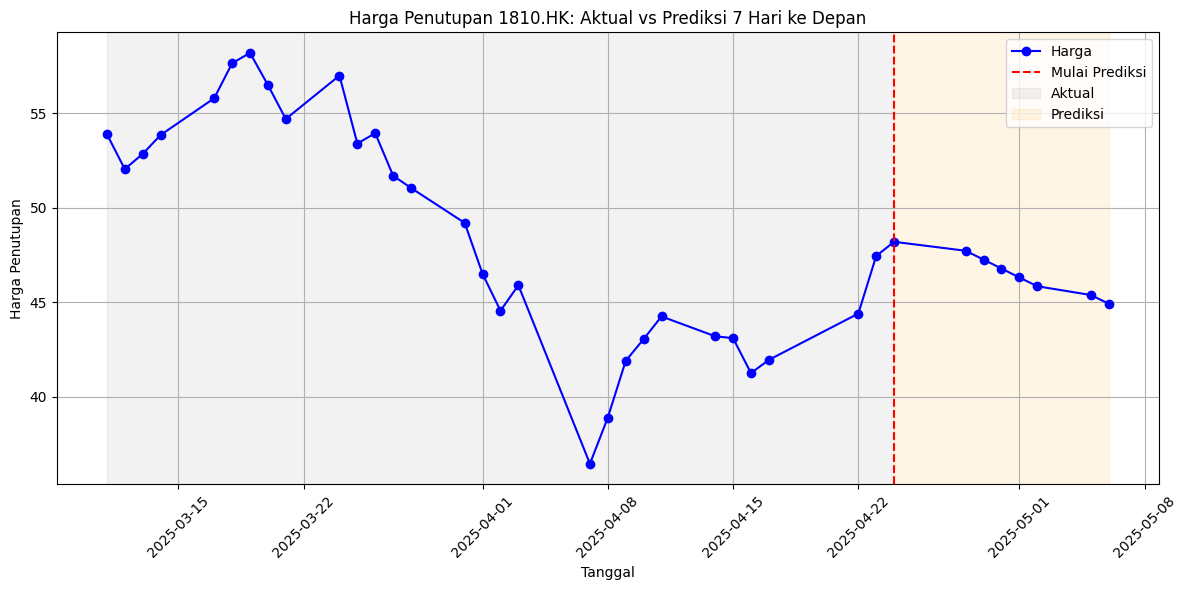

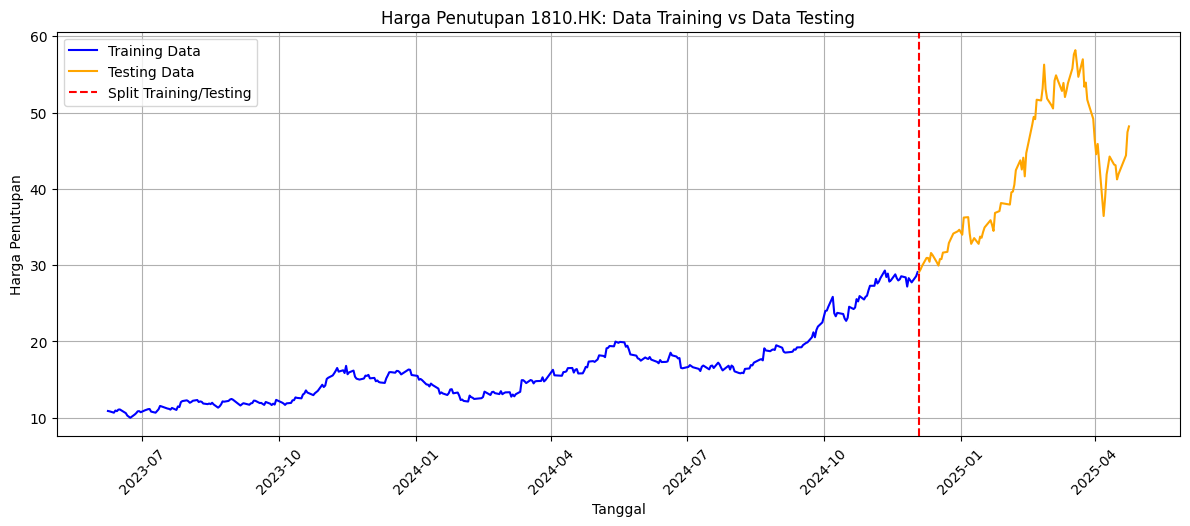


✅ Semua hasil prediksi disimpan ke: prediksi_7hari.csv


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from ta.momentum import RSIIndicator, ROCIndicator
from ta.trend import MACD, EMAIndicator, WMAIndicator
from ta.volatility import BollingerBands

tickers = ['SONY', '1810.HK']
sp500_ticker = '^GSPC'
start_date = (datetime.today() - pd.Timedelta(days=730)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

df_all_preds = pd.DataFrame()

for ticker in tickers:
    print(f"\n================= MEMPROSES {ticker} =================")
    df = yf.download(ticker, start=start_date, end=end_date)
    sp500 = yf.download(sp500_ticker, start=start_date, end=end_date)

    if df.empty or len(df) < 100:
        print(f"{ticker} gagal: data terlalu sedikit")
        continue

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    sp500 = sp500[['Close']].rename(columns={'Close': 'SP500_Close'}).dropna()
    df = df.join(sp500, how='inner')

    # === FITUR TEKNIKAL & INTERAKSI ===
    df['Volume'] = np.log1p(df['Volume'])
    df['Lag1'] = df['Close'].shift(1)
    df['MA5'] = df['Close'].rolling(5).mean()
    df['MA10'] = df['Close'].rolling(10).mean()
    df['EMA10'] = EMAIndicator(close=df['Close'].squeeze(), window=10).ema_indicator()
    df['RSI'] = RSIIndicator(close=df['Close'].squeeze(), window=14).rsi()
    df['MACD'] = MACD(close=df['Close'].squeeze()).macd()
    df['BB_high'] = BollingerBands(close=df['Close'].squeeze()).bollinger_hband()
    df['BB_low'] = BollingerBands(close=df['Close'].squeeze()).bollinger_lband()
    df['Return'] = df['Close'].pct_change()
    df['RollingReturn5'] = df['Return'].rolling(5).mean()
    df['RollingReturn10'] = df['Return'].rolling(10).mean()
    df['Volatility5'] = df['Close'].pct_change().rolling(5).std()
    df['Price_Level'] = pd.qcut(df['Close'].iloc[:, 0] if isinstance(df['Close'], pd.DataFrame) else df['Close'], q=4, labels=False)

    df['Target'] = df['Close'].shift(-1) - df['Close']
    df.dropna(inplace=True)

    features = [col for col in df.columns if col not in ['Target', 'Close']]
    X = df[features]
    y = df['Target']

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {
        'n_estimators': [300],
        'learning_rate': [0.01],
        'max_depth': [4],
        'subsample': [0.8],
        'colsample_bytree': [0.9]
    }

    model = XGBRegressor(random_state=42)
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_
    best_model.fit(X_train_scaled, y_train)

    y_pred = best_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    last_date = df.index[-1]
    last_close = df['Close'].iloc[-1].item()
    last_input = X.iloc[[-1]]
    last_scaled = scaler.transform(last_input)
    predicted_delta = best_model.predict(last_scaled)[0]
    final_pred = last_close + predicted_delta

    next_date = last_date + timedelta(days=1)
    while next_date.weekday() >= 5:
        next_date += timedelta(days=1)

    print(f"\nMAE   : {mae:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print(f"R²    : {r2:.4f}")
    print(f"Tanggal penutupan terakhir: {last_date.strftime('%Y-%m-%d')}")
    print(f"Harga penutupan terakhir  : {last_close:.2f}")
    print(f"Prediksi penutupan        : {final_pred:.2f} (untuk tanggal {next_date.strftime('%Y-%m-%d')})")

    actual_data = yf.download(ticker, start=next_date.strftime('%Y-%m-%d'), end=(next_date + timedelta(days=1)).strftime('%Y-%m-%d'))
    if not actual_data.empty:
        harga_aktual_besok = actual_data['Close'].iloc[0].item()
        selisih = abs(final_pred - harga_aktual_besok)
        mape_real = (selisih / harga_aktual_besok) * 100
        akurasi_real = 100 - mape_real
        print("\n📈 Evaluasi Real (Auto Yahoo Finance):")
        print(f"Harga aktual         : {harga_aktual_besok:.2f}")
        print(f"Selisih prediksi     : {selisih:.2f}")
        print(f"MAPE terhadap aktual : {mape_real:.2f}%")
        print(f"Akurasi prediksi     : {akurasi_real:.2f}%")

    # === PREDIKSI 7 HARI KE DEPAN ===
    n_future = 7
    future_dates = []
    future_predictions = []

    last_known_close = last_close
    last_known_input = last_input.copy()

    for i in range(n_future):
        scaled_input = scaler.transform(last_known_input)
        predicted_delta = best_model.predict(scaled_input)[0]
        predicted_price = last_known_close + predicted_delta

        future_predictions.append(predicted_price)
        next_date += timedelta(days=1)
        while next_date.weekday() >= 5:
            next_date += timedelta(days=1)
        future_dates.append(next_date)

        new_row = last_known_input.copy()
        new_row['Lag1'] = predicted_price
        close_series = df['Close'].values.flatten().tolist() + future_predictions[:i+1]

        new_row['MA5'] = np.mean(close_series[-5:]) if len(close_series) >= 5 else np.nan
        new_row['MA10'] = np.mean(close_series[-10:]) if len(close_series) >= 10 else np.nan
        new_row['EMA10'] = EMAIndicator(pd.Series(close_series)).ema_indicator().iloc[-1]
        new_row['RSI'] = RSIIndicator(pd.Series(close_series)).rsi().iloc[-1]
        new_row['MACD'] = MACD(pd.Series(close_series)).macd().iloc[-1]
        new_row['BB_high'] = BollingerBands(pd.Series(close_series)).bollinger_hband().iloc[-1]
        new_row['BB_low'] = BollingerBands(pd.Series(close_series)).bollinger_lband().iloc[-1]
        new_row['Return'] = (predicted_price - last_known_close) / last_known_close
        new_row['RollingReturn5'] = pd.Series(close_series).pct_change().rolling(5).mean().iloc[-1]
        new_row['RollingReturn10'] = pd.Series(close_series).pct_change().rolling(10).mean().iloc[-1]
        new_row['Volatility5'] = pd.Series(close_series).pct_change().rolling(5).std().iloc[-1]
        new_row['Price_Level'] = pd.qcut(pd.Series(close_series), q=4, labels=False).iloc[-1]

        last_known_input = new_row
        last_known_close = predicted_price

    print("\nPrediksi 7 hari ke depan:")
    for d, p in zip(future_dates, future_predictions):
        print(f"Prediksi untuk tanggal {d.strftime('%Y-%m-%d')} : {p:.2f}")

    # Gabungkan ke DataFrame global
    df_temp = pd.DataFrame({
        'Tanggal Prediksi': [d.strftime('%Y-%m-%d') for d in future_dates],
        ticker: [round(p, 2) for p in future_predictions]
    })

    # Merge ke df_all_preds
    if df_all_preds.empty:
        df_all_preds = df_temp
    else:
        df_all_preds = pd.merge(df_all_preds, df_temp, on='Tanggal Prediksi', how='outer')

    # === GRAFIK PREDIKSI 7 HARI ===
    df_plot = df.tail(30).copy()
    df_plot_dates = df_plot.index.tolist()

    extended_dates = df_plot_dates + future_dates
    extended_prices = df_plot['Close'].values.flatten().tolist() + future_predictions

    plt.figure(figsize=(12, 6))
    plt.plot(extended_dates, extended_prices, label='Harga', color='blue', marker='o')
    plt.axvline(x=df_plot_dates[-1], color='red', linestyle='--', label='Mulai Prediksi')
    plt.axvspan(df_plot_dates[0], df_plot_dates[-1], color='grey', alpha=0.1, label='Aktual')
    plt.axvspan(df_plot_dates[-1], extended_dates[-1], color='orange', alpha=0.1, label='Prediksi')
    plt.title(f'Harga Penutupan {ticker}: Aktual vs Prediksi 7 Hari ke Depan')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot Split Training/Testing ---
    # Tentukan proporsi split (80% training, 20% testing)
    train_size = 0.8
    split_index = int(len(df) * train_size)

    # Bagi data
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]

    # Plot Data
    plt.figure(figsize=(12, 5))
    plt.plot(train_data.index, train_data['Close'], label='Training Data', color='blue')
    plt.plot(test_data.index, test_data['Close'], label='Testing Data', color='orange')

    # Garis vertikal sebagai pemisah
    plt.axvline(x=df.index[split_index], color='red', linestyle='--', label='Split Training/Testing')

    # Format akhir plot
    plt.title(f'Harga Penutupan {ticker}: Data Training vs Data Testing')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # === SIMPAN SEMUA HASIL PREDIKSI KE SATU FILE CSV ===
    csv_all_filename = f'prediksi_7hari.csv'
    df_all_preds.to_csv(csv_all_filename, index=False)
    print(f"\n✅ Semua hasil prediksi disimpan ke: {csv_all_filename}")



PREDIKSI 1 BULAN

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


================= MEMPROSES SONY =================



[*********************100%***********************]  1 of 1 completed


MAE   : 0.0586
MSE   : 0.0199
RMSE  : 0.1411
R²    : 0.9151
Tanggal penutupan terakhir: 2025-04-24
Harga penutupan terakhir  : 25.12
Prediksi penutupan        : 24.98 (untuk tanggal 2025-04-25)

📈 Evaluasi Real (Auto Yahoo Finance):
Harga aktual         : 24.97
Selisih prediksi     : 0.01
MAPE terhadap aktual : 0.03%
Akurasi prediksi     : 99.97%



Prediksi 1 bulan ke depan:
Prediksi untuk tanggal 2025-04-28 : 24.98
Prediksi untuk tanggal 2025-04-29 : 24.83
Prediksi untuk tanggal 2025-04-30 : 24.69
Prediksi untuk tanggal 2025-05-01 : 24.54
Prediksi untuk tanggal 2025-05-02 : 24.39
Prediksi untuk tanggal 2025-05-05 : 24.25
Prediksi untuk tanggal 2025-05-06 : 24.10
Prediksi untuk tanggal 2025-05-07 : 23.95
Prediksi untuk tanggal 2025-05-08 : 23.79
Prediksi untuk tanggal 2025-05-09 : 23.63
Prediksi untuk tanggal 2025-05-12 : 23.47
Prediksi untuk tanggal 2025-05-13 : 23.31
Prediksi untuk tanggal 2025-05-14 : 23.16
Prediksi untuk tanggal 2025-05-15 : 23.00
Prediksi untuk tanggal 2025-05-16 : 22.84
Prediksi untuk tanggal 2025-05-19 : 22.68
Prediksi untuk tanggal 2025-05-20 : 22.52
Prediksi untuk tanggal 2025-05-21 : 22.36
Prediksi untuk tanggal 2025-05-22 : 22.21
Prediksi untuk tanggal 2025-05-23 : 22.05
Prediksi untuk tanggal 2025-05-26 : 21.89
Prediksi untuk tanggal 2025-05-27 : 21.73
Prediksi untuk tanggal 2025-05-28 : 21.57
Predik

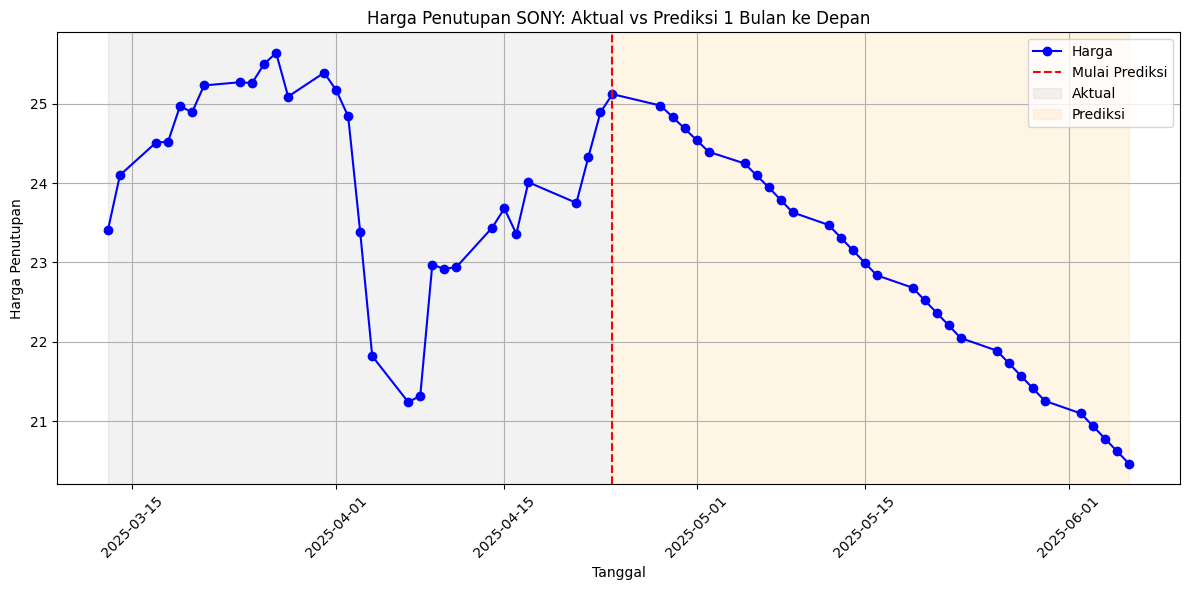

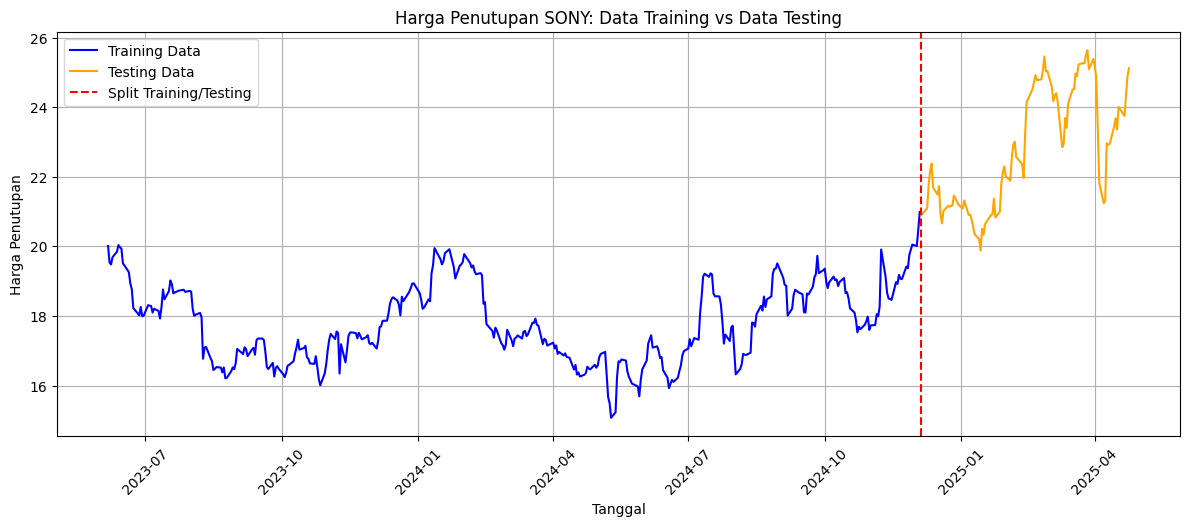

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Semua hasil prediksi disimpan ke: prediksi_1bulan.csv

================= MEMPROSES 1810.HK =================



[*********************100%***********************]  1 of 1 completed


MAE   : 0.5441
MSE   : 1.3381
RMSE  : 1.1568
R²    : 0.6081
Tanggal penutupan terakhir: 2025-04-24
Harga penutupan terakhir  : 48.20
Prediksi penutupan        : 47.73 (untuk tanggal 2025-04-25)

📈 Evaluasi Real (Auto Yahoo Finance):
Harga aktual         : 47.70
Selisih prediksi     : 0.03
MAPE terhadap aktual : 0.05%
Akurasi prediksi     : 99.95%



Prediksi 1 bulan ke depan:
Prediksi untuk tanggal 2025-04-28 : 47.73
Prediksi untuk tanggal 2025-04-29 : 47.26
Prediksi untuk tanggal 2025-04-30 : 46.79
Prediksi untuk tanggal 2025-05-01 : 46.31
Prediksi untuk tanggal 2025-05-02 : 45.85
Prediksi untuk tanggal 2025-05-05 : 45.38
Prediksi untuk tanggal 2025-05-06 : 44.92
Prediksi untuk tanggal 2025-05-07 : 44.46
Prediksi untuk tanggal 2025-05-08 : 43.99
Prediksi untuk tanggal 2025-05-09 : 43.53
Prediksi untuk tanggal 2025-05-12 : 43.06
Prediksi untuk tanggal 2025-05-13 : 42.60
Prediksi untuk tanggal 2025-05-14 : 42.14
Prediksi untuk tanggal 2025-05-15 : 41.67
Prediksi untuk tanggal 2025-05-16 : 41.21
Prediksi untuk tanggal 2025-05-19 : 40.74
Prediksi untuk tanggal 2025-05-20 : 40.28
Prediksi untuk tanggal 2025-05-21 : 39.81
Prediksi untuk tanggal 2025-05-22 : 39.35
Prediksi untuk tanggal 2025-05-23 : 38.88
Prediksi untuk tanggal 2025-05-26 : 38.42
Prediksi untuk tanggal 2025-05-27 : 37.96
Prediksi untuk tanggal 2025-05-28 : 37.49
Predik

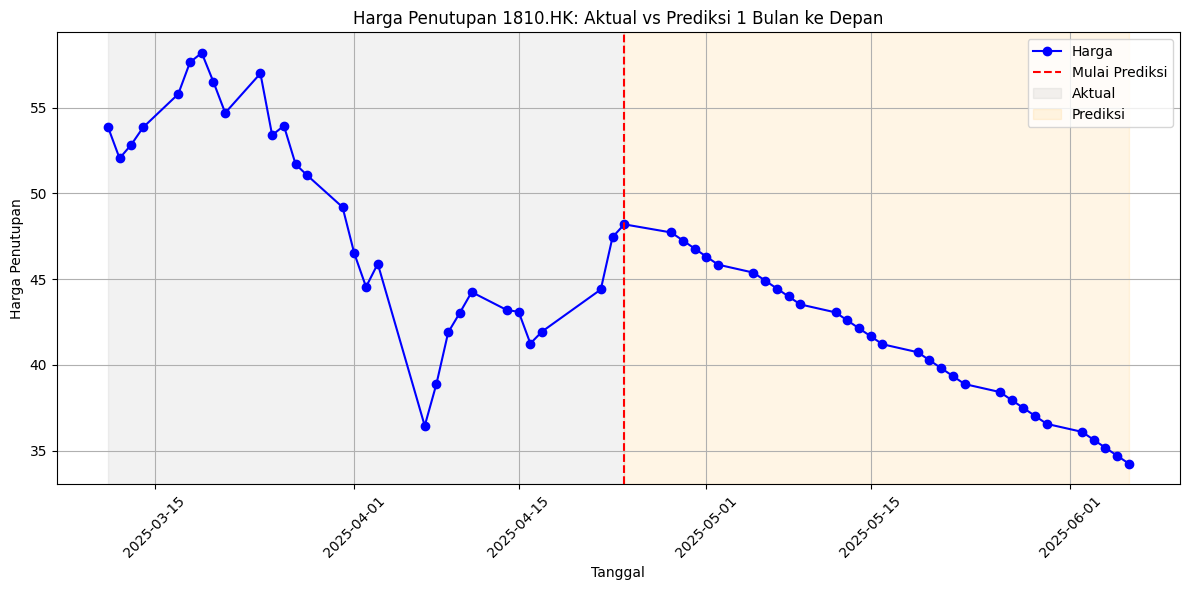

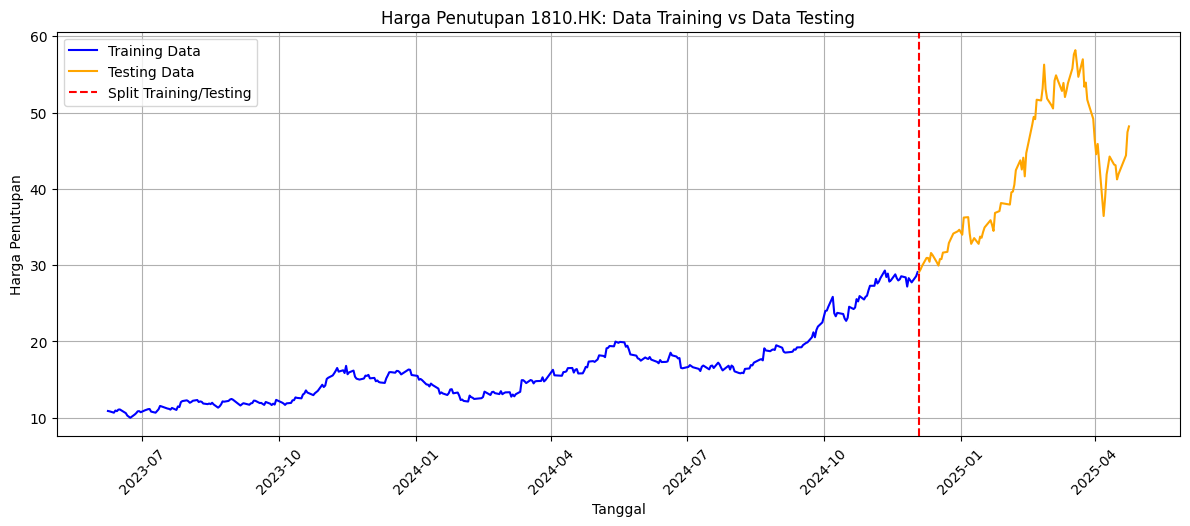


✅ Semua hasil prediksi disimpan ke: prediksi_1bulan.csv


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from ta.momentum import RSIIndicator, ROCIndicator
from ta.trend import MACD, EMAIndicator, WMAIndicator
from ta.volatility import BollingerBands

tickers = ['SONY', '1810.HK']
sp500_ticker = '^GSPC'
start_date = (datetime.today() - pd.Timedelta(days=730)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

df_all_preds = pd.DataFrame()

for ticker in tickers:
    print(f"\n================= MEMPROSES {ticker} =================")
    df = yf.download(ticker, start=start_date, end=end_date)
    sp500 = yf.download(sp500_ticker, start=start_date, end=end_date)

    if df.empty or len(df) < 100:
        print(f"{ticker} gagal: data terlalu sedikit")
        continue

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    sp500 = sp500[['Close']].rename(columns={'Close': 'SP500_Close'}).dropna()
    df = df.join(sp500, how='inner')

    # === FITUR TEKNIKAL & INTERAKSI ===
    df['Volume'] = np.log1p(df['Volume'])
    df['Lag1'] = df['Close'].shift(1)
    df['MA5'] = df['Close'].rolling(5).mean()
    df['MA10'] = df['Close'].rolling(10).mean()
    df['EMA10'] = EMAIndicator(close=df['Close'].squeeze(), window=10).ema_indicator()
    df['RSI'] = RSIIndicator(close=df['Close'].squeeze(), window=14).rsi()
    df['MACD'] = MACD(close=df['Close'].squeeze()).macd()
    df['BB_high'] = BollingerBands(close=df['Close'].squeeze()).bollinger_hband()
    df['BB_low'] = BollingerBands(close=df['Close'].squeeze()).bollinger_lband()
    df['Return'] = df['Close'].pct_change()
    df['RollingReturn5'] = df['Return'].rolling(5).mean()
    df['RollingReturn10'] = df['Return'].rolling(10).mean()
    df['Volatility5'] = df['Close'].pct_change().rolling(5).std()
    df['Price_Level'] = pd.qcut(df['Close'].iloc[:, 0] if isinstance(df['Close'], pd.DataFrame) else df['Close'], q=4, labels=False)

    df['Target'] = df['Close'].shift(-1) - df['Close']
    df.dropna(inplace=True)

    features = [col for col in df.columns if col not in ['Target', 'Close']]
    X = df[features]
    y = df['Target']

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {
        'n_estimators': [300],
        'learning_rate': [0.01],
        'max_depth': [4],
        'subsample': [0.8],
        'colsample_bytree': [0.9]
    }

    model = XGBRegressor(random_state=42)
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_
    best_model.fit(X_train_scaled, y_train)

    y_pred = best_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    last_date = df.index[-1]
    last_close = df['Close'].iloc[-1].item()
    last_input = X.iloc[[-1]]
    last_scaled = scaler.transform(last_input)
    predicted_delta = best_model.predict(last_scaled)[0]
    final_pred = last_close + predicted_delta

    next_date = last_date + timedelta(days=1)
    while next_date.weekday() >= 5:
        next_date += timedelta(days=1)

    print(f"\nMAE   : {mae:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print(f"R²    : {r2:.4f}")
    print(f"Tanggal penutupan terakhir: {last_date.strftime('%Y-%m-%d')}")
    print(f"Harga penutupan terakhir  : {last_close:.2f}")
    print(f"Prediksi penutupan        : {final_pred:.2f} (untuk tanggal {next_date.strftime('%Y-%m-%d')})")

    actual_data = yf.download(ticker, start=next_date.strftime('%Y-%m-%d'), end=(next_date + timedelta(days=1)).strftime('%Y-%m-%d'))
    if not actual_data.empty:
        harga_aktual_besok = actual_data['Close'].iloc[0].item()
        selisih = abs(final_pred - harga_aktual_besok)
        mape_real = (selisih / harga_aktual_besok) * 100
        akurasi_real = 100 - mape_real
        print("\n📈 Evaluasi Real (Auto Yahoo Finance):")
        print(f"Harga aktual         : {harga_aktual_besok:.2f}")
        print(f"Selisih prediksi     : {selisih:.2f}")
        print(f"MAPE terhadap aktual : {mape_real:.2f}%")
        print(f"Akurasi prediksi     : {akurasi_real:.2f}%")

    # === PREDIKSI 1 BULAN KE DEPAN ===
    n_future = 30
    future_dates = []
    future_predictions = []

    last_known_close = last_close
    last_known_input = last_input.copy()

    for i in range(n_future):
        scaled_input = scaler.transform(last_known_input)
        predicted_delta = best_model.predict(scaled_input)[0]
        predicted_price = last_known_close + predicted_delta

        future_predictions.append(predicted_price)
        next_date += timedelta(days=1)
        while next_date.weekday() >= 5:
            next_date += timedelta(days=1)
        future_dates.append(next_date)

        new_row = last_known_input.copy()
        new_row['Lag1'] = predicted_price
        close_series = df['Close'].values.flatten().tolist() + future_predictions[:i+1]

        new_row['MA5'] = np.mean(close_series[-5:]) if len(close_series) >= 5 else np.nan
        new_row['MA10'] = np.mean(close_series[-10:]) if len(close_series) >= 10 else np.nan
        new_row['EMA10'] = EMAIndicator(pd.Series(close_series)).ema_indicator().iloc[-1]
        new_row['RSI'] = RSIIndicator(pd.Series(close_series)).rsi().iloc[-1]
        new_row['MACD'] = MACD(pd.Series(close_series)).macd().iloc[-1]
        new_row['BB_high'] = BollingerBands(pd.Series(close_series)).bollinger_hband().iloc[-1]
        new_row['BB_low'] = BollingerBands(pd.Series(close_series)).bollinger_lband().iloc[-1]
        new_row['Return'] = (predicted_price - last_known_close) / last_known_close
        new_row['RollingReturn5'] = pd.Series(close_series).pct_change().rolling(5).mean().iloc[-1]
        new_row['RollingReturn10'] = pd.Series(close_series).pct_change().rolling(10).mean().iloc[-1]
        new_row['Volatility5'] = pd.Series(close_series).pct_change().rolling(5).std().iloc[-1]
        new_row['Price_Level'] = pd.qcut(pd.Series(close_series), q=4, labels=False).iloc[-1]

        last_known_input = new_row
        last_known_close = predicted_price

    print("\nPrediksi 1 bulan ke depan:")
    for d, p in zip(future_dates, future_predictions):
        print(f"Prediksi untuk tanggal {d.strftime('%Y-%m-%d')} : {p:.2f}")

    # Gabungkan ke DataFrame global
    df_temp = pd.DataFrame({
        'Tanggal Prediksi': [d.strftime('%Y-%m-%d') for d in future_dates],
        ticker: [round(p, 2) for p in future_predictions]
    })

    # Merge ke df_all_preds
    if df_all_preds.empty:
        df_all_preds = df_temp
    else:
        df_all_preds = pd.merge(df_all_preds, df_temp, on='Tanggal Prediksi', how='outer')

    # === GRAFIK PREDIKSI ===
    df_plot = df.tail(30).copy()
    df_plot_dates = df_plot.index.tolist()

    extended_dates = df_plot_dates + future_dates
    extended_prices = df_plot['Close'].values.flatten().tolist() + future_predictions

    plt.figure(figsize=(12, 6))
    plt.plot(extended_dates, extended_prices, label='Harga', color='blue', marker='o')
    plt.axvline(x=df_plot_dates[-1], color='red', linestyle='--', label='Mulai Prediksi')
    plt.axvspan(df_plot_dates[0], df_plot_dates[-1], color='grey', alpha=0.1, label='Aktual')
    plt.axvspan(df_plot_dates[-1], extended_dates[-1], color='orange', alpha=0.1, label='Prediksi')
    plt.title(f'Harga Penutupan {ticker}: Aktual vs Prediksi 1 Bulan ke Depan')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot Split Training/Testing ---
    # Tentukan proporsi split (80% training, 20% testing)
    train_size = 0.8
    split_index = int(len(df) * train_size)

    # Bagi data
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]

    # Plot Data
    plt.figure(figsize=(12, 5))
    plt.plot(train_data.index, train_data['Close'], label='Training Data', color='blue')
    plt.plot(test_data.index, test_data['Close'], label='Testing Data', color='orange')

    # Garis vertikal sebagai pemisah
    plt.axvline(x=df.index[split_index], color='red', linestyle='--', label='Split Training/Testing')

    # Format akhir plot
    plt.title(f'Harga Penutupan {ticker}: Data Training vs Data Testing')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # === SIMPAN SEMUA HASIL PREDIKSI KE SATU FILE CSV ===
    csv_all_filename = f'prediksi_1bulan.csv'
    df_all_preds.to_csv(csv_all_filename, index=False)
    print(f"\n✅ Semua hasil prediksi disimpan ke: {csv_all_filename}")



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


================= MEMPROSES SONY =================



[*********************100%***********************]  1 of 1 completed


MAE   : 0.0586
MSE   : 0.0199
RMSE  : 0.1411
R²    : 0.9151
Tanggal penutupan terakhir: 2025-04-24
Harga penutupan terakhir  : 25.12
Prediksi penutupan        : 24.98 (untuk tanggal 2025-04-25)

📈 Evaluasi Real (Auto Yahoo Finance):
Harga aktual         : 24.97
Selisih prediksi     : 0.01
MAPE terhadap aktual : 0.03%
Akurasi prediksi     : 99.97%



Prediksi 2 bulan ke depan:
Prediksi untuk tanggal 2025-04-28 : 24.98
Prediksi untuk tanggal 2025-04-29 : 24.83
Prediksi untuk tanggal 2025-04-30 : 24.69
Prediksi untuk tanggal 2025-05-01 : 24.54
Prediksi untuk tanggal 2025-05-02 : 24.39
Prediksi untuk tanggal 2025-05-05 : 24.25
Prediksi untuk tanggal 2025-05-06 : 24.10
Prediksi untuk tanggal 2025-05-07 : 23.95
Prediksi untuk tanggal 2025-05-08 : 23.79
Prediksi untuk tanggal 2025-05-09 : 23.63
Prediksi untuk tanggal 2025-05-12 : 23.47
Prediksi untuk tanggal 2025-05-13 : 23.31
Prediksi untuk tanggal 2025-05-14 : 23.16
Prediksi untuk tanggal 2025-05-15 : 23.00
Prediksi untuk tanggal 2025-05-16 : 22.84
Prediksi untuk tanggal 2025-05-19 : 22.68
Prediksi untuk tanggal 2025-05-20 : 22.52
Prediksi untuk tanggal 2025-05-21 : 22.36
Prediksi untuk tanggal 2025-05-22 : 22.21
Prediksi untuk tanggal 2025-05-23 : 22.05
Prediksi untuk tanggal 2025-05-26 : 21.89
Prediksi untuk tanggal 2025-05-27 : 21.73
Prediksi untuk tanggal 2025-05-28 : 21.57
Predik

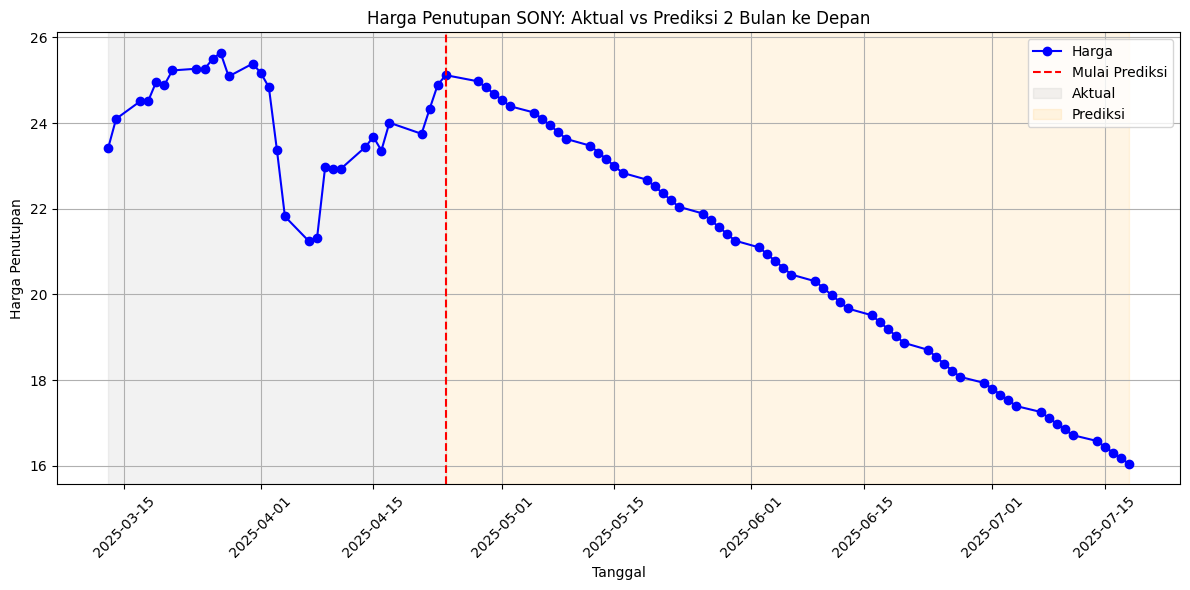

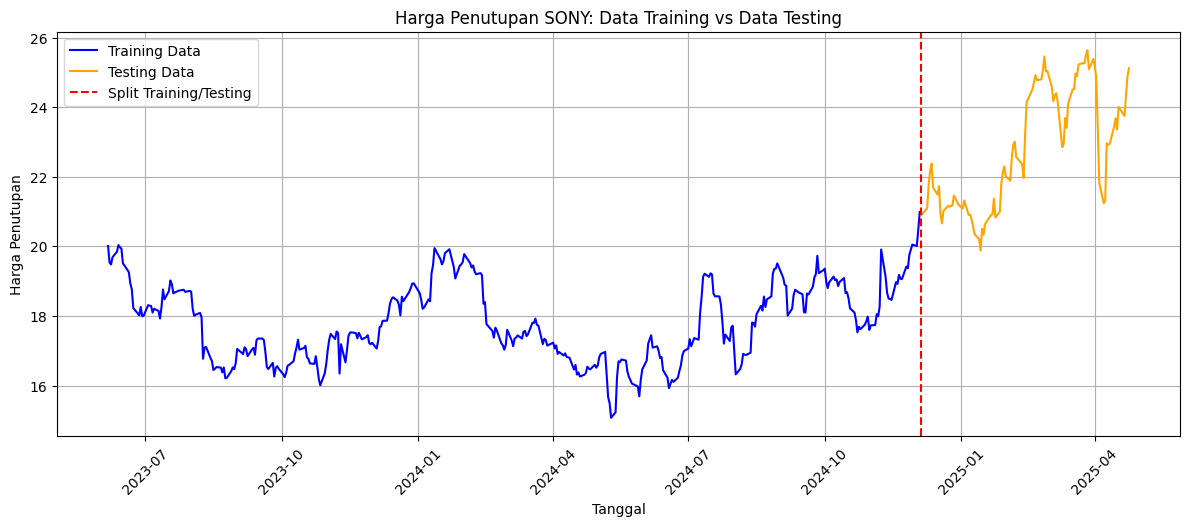

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Semua hasil prediksi disimpan ke: prediksi_2bulan.csv

================= MEMPROSES 1810.HK =================



[*********************100%***********************]  1 of 1 completed


MAE   : 0.5441
MSE   : 1.3381
RMSE  : 1.1568
R²    : 0.6081
Tanggal penutupan terakhir: 2025-04-24
Harga penutupan terakhir  : 48.20
Prediksi penutupan        : 47.73 (untuk tanggal 2025-04-25)

📈 Evaluasi Real (Auto Yahoo Finance):
Harga aktual         : 47.70
Selisih prediksi     : 0.03
MAPE terhadap aktual : 0.05%
Akurasi prediksi     : 99.95%



Prediksi 2 bulan ke depan:
Prediksi untuk tanggal 2025-04-28 : 47.73
Prediksi untuk tanggal 2025-04-29 : 47.26
Prediksi untuk tanggal 2025-04-30 : 46.79
Prediksi untuk tanggal 2025-05-01 : 46.31
Prediksi untuk tanggal 2025-05-02 : 45.85
Prediksi untuk tanggal 2025-05-05 : 45.38
Prediksi untuk tanggal 2025-05-06 : 44.92
Prediksi untuk tanggal 2025-05-07 : 44.46
Prediksi untuk tanggal 2025-05-08 : 43.99
Prediksi untuk tanggal 2025-05-09 : 43.53
Prediksi untuk tanggal 2025-05-12 : 43.06
Prediksi untuk tanggal 2025-05-13 : 42.60
Prediksi untuk tanggal 2025-05-14 : 42.14
Prediksi untuk tanggal 2025-05-15 : 41.67
Prediksi untuk tanggal 2025-05-16 : 41.21
Prediksi untuk tanggal 2025-05-19 : 40.74
Prediksi untuk tanggal 2025-05-20 : 40.28
Prediksi untuk tanggal 2025-05-21 : 39.81
Prediksi untuk tanggal 2025-05-22 : 39.35
Prediksi untuk tanggal 2025-05-23 : 38.88
Prediksi untuk tanggal 2025-05-26 : 38.42
Prediksi untuk tanggal 2025-05-27 : 37.96
Prediksi untuk tanggal 2025-05-28 : 37.49
Predik

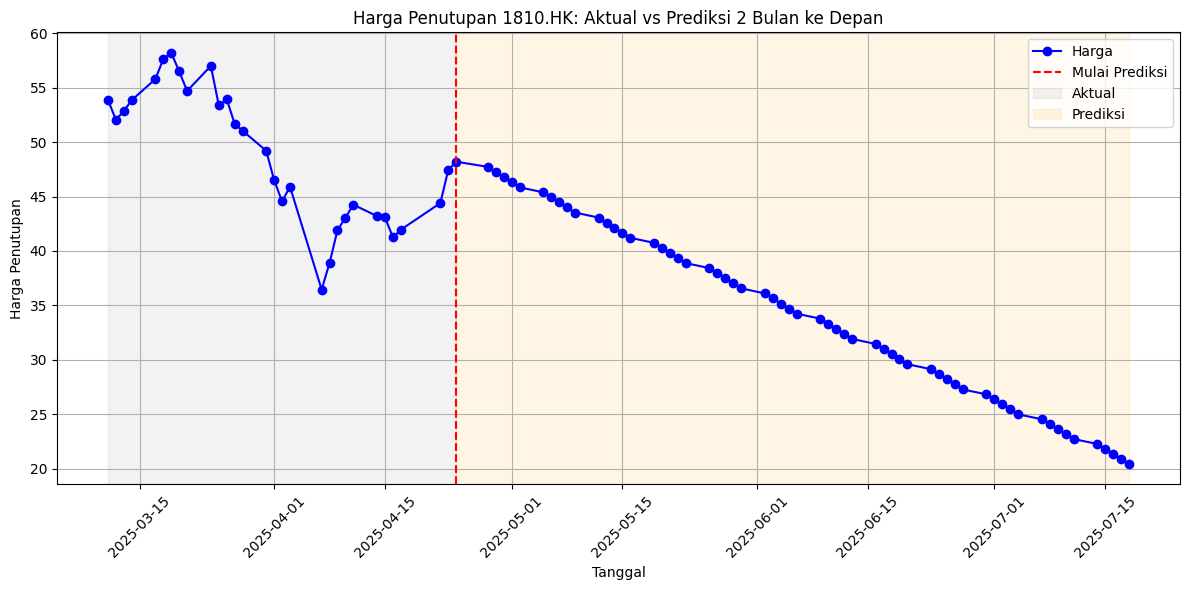

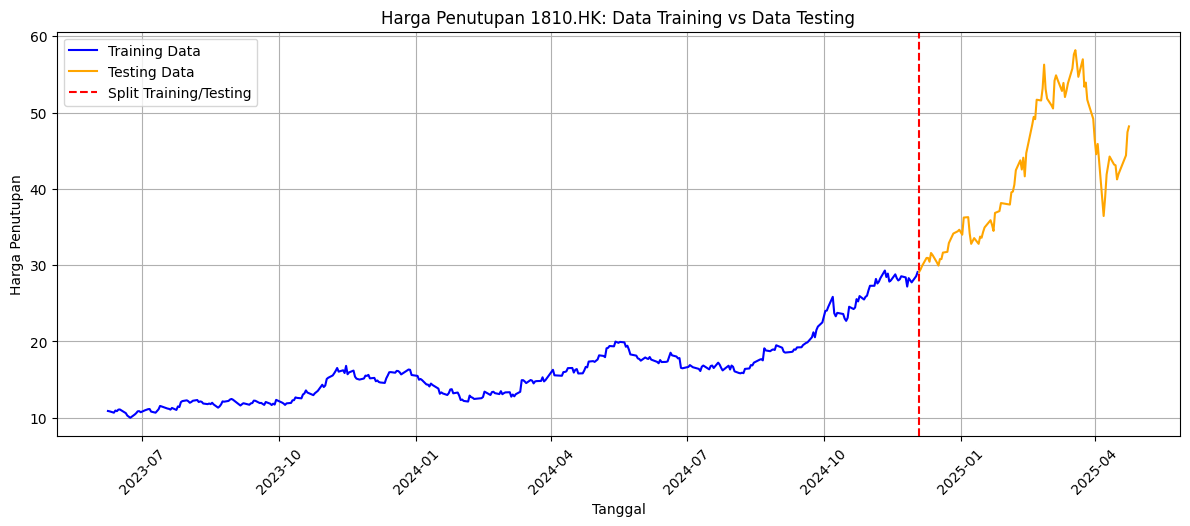


✅ Semua hasil prediksi disimpan ke: prediksi_2bulan.csv


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from ta.momentum import RSIIndicator, ROCIndicator
from ta.trend import MACD, EMAIndicator, WMAIndicator
from ta.volatility import BollingerBands

tickers = ['SONY', '1810.HK']
sp500_ticker = '^GSPC'
start_date = (datetime.today() - pd.Timedelta(days=730)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

df_all_preds = pd.DataFrame()

for ticker in tickers:
    print(f"\n================= MEMPROSES {ticker} =================")
    df = yf.download(ticker, start=start_date, end=end_date)
    sp500 = yf.download(sp500_ticker, start=start_date, end=end_date)

    if df.empty or len(df) < 100:
        print(f"{ticker} gagal: data terlalu sedikit")
        continue

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    sp500 = sp500[['Close']].rename(columns={'Close': 'SP500_Close'}).dropna()
    df = df.join(sp500, how='inner')

    # === FITUR TEKNIKAL & INTERAKSI ===
    df['Volume'] = np.log1p(df['Volume'])
    df['Lag1'] = df['Close'].shift(1)
    df['MA5'] = df['Close'].rolling(5).mean()
    df['MA10'] = df['Close'].rolling(10).mean()
    df['EMA10'] = EMAIndicator(close=df['Close'].squeeze(), window=10).ema_indicator()
    df['RSI'] = RSIIndicator(close=df['Close'].squeeze(), window=14).rsi()
    df['MACD'] = MACD(close=df['Close'].squeeze()).macd()
    df['BB_high'] = BollingerBands(close=df['Close'].squeeze()).bollinger_hband()
    df['BB_low'] = BollingerBands(close=df['Close'].squeeze()).bollinger_lband()
    df['Return'] = df['Close'].pct_change()
    df['RollingReturn5'] = df['Return'].rolling(5).mean()
    df['RollingReturn10'] = df['Return'].rolling(10).mean()
    df['Volatility5'] = df['Close'].pct_change().rolling(5).std()
    df['Price_Level'] = pd.qcut(df['Close'].iloc[:, 0] if isinstance(df['Close'], pd.DataFrame) else df['Close'], q=4, labels=False)

    df['Target'] = df['Close'].shift(-1) - df['Close']
    df.dropna(inplace=True)

    features = [col for col in df.columns if col not in ['Target', 'Close']]
    X = df[features]
    y = df['Target']

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {
        'n_estimators': [300],
        'learning_rate': [0.01],
        'max_depth': [4],
        'subsample': [0.8],
        'colsample_bytree': [0.9]
    }

    model = XGBRegressor(random_state=42)
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_
    best_model.fit(X_train_scaled, y_train)

    y_pred = best_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    last_date = df.index[-1]
    last_close = df['Close'].iloc[-1].item()
    last_input = X.iloc[[-1]]
    last_scaled = scaler.transform(last_input)
    predicted_delta = best_model.predict(last_scaled)[0]
    final_pred = last_close + predicted_delta

    next_date = last_date + timedelta(days=1)
    while next_date.weekday() >= 5:
        next_date += timedelta(days=1)

    print(f"\nMAE   : {mae:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print(f"R²    : {r2:.4f}")
    print(f"Tanggal penutupan terakhir: {last_date.strftime('%Y-%m-%d')}")
    print(f"Harga penutupan terakhir  : {last_close:.2f}")
    print(f"Prediksi penutupan        : {final_pred:.2f} (untuk tanggal {next_date.strftime('%Y-%m-%d')})")

    actual_data = yf.download(ticker, start=next_date.strftime('%Y-%m-%d'), end=(next_date + timedelta(days=1)).strftime('%Y-%m-%d'))
    if not actual_data.empty:
        harga_aktual_besok = actual_data['Close'].iloc[0].item()
        selisih = abs(final_pred - harga_aktual_besok)
        mape_real = (selisih / harga_aktual_besok) * 100
        akurasi_real = 100 - mape_real
        print("\n📈 Evaluasi Real (Auto Yahoo Finance):")
        print(f"Harga aktual         : {harga_aktual_besok:.2f}")
        print(f"Selisih prediksi     : {selisih:.2f}")
        print(f"MAPE terhadap aktual : {mape_real:.2f}%")
        print(f"Akurasi prediksi     : {akurasi_real:.2f}%")

    # === PREDIKSI 2 BULAN KE DEPAN ===
    n_future = 60
    future_dates = []
    future_predictions = []

    last_known_close = last_close
    last_known_input = last_input.copy()

    for i in range(n_future):
        scaled_input = scaler.transform(last_known_input)
        predicted_delta = best_model.predict(scaled_input)[0]
        predicted_price = last_known_close + predicted_delta

        future_predictions.append(predicted_price)
        next_date += timedelta(days=1)
        while next_date.weekday() >= 5:
            next_date += timedelta(days=1)
        future_dates.append(next_date)

        new_row = last_known_input.copy()
        new_row['Lag1'] = predicted_price
        close_series = df['Close'].values.flatten().tolist() + future_predictions[:i+1]

        new_row['MA5'] = np.mean(close_series[-5:]) if len(close_series) >= 5 else np.nan
        new_row['MA10'] = np.mean(close_series[-10:]) if len(close_series) >= 10 else np.nan
        new_row['EMA10'] = EMAIndicator(pd.Series(close_series)).ema_indicator().iloc[-1]
        new_row['RSI'] = RSIIndicator(pd.Series(close_series)).rsi().iloc[-1]
        new_row['MACD'] = MACD(pd.Series(close_series)).macd().iloc[-1]
        new_row['BB_high'] = BollingerBands(pd.Series(close_series)).bollinger_hband().iloc[-1]
        new_row['BB_low'] = BollingerBands(pd.Series(close_series)).bollinger_lband().iloc[-1]
        new_row['Return'] = (predicted_price - last_known_close) / last_known_close
        new_row['RollingReturn5'] = pd.Series(close_series).pct_change().rolling(5).mean().iloc[-1]
        new_row['RollingReturn10'] = pd.Series(close_series).pct_change().rolling(10).mean().iloc[-1]
        new_row['Volatility5'] = pd.Series(close_series).pct_change().rolling(5).std().iloc[-1]
        new_row['Price_Level'] = pd.qcut(pd.Series(close_series), q=4, labels=False).iloc[-1]

        last_known_input = new_row
        last_known_close = predicted_price

    print("\nPrediksi 2 bulan ke depan:")
    for d, p in zip(future_dates, future_predictions):
        print(f"Prediksi untuk tanggal {d.strftime('%Y-%m-%d')} : {p:.2f}")

    # Gabungkan ke DataFrame global
    df_temp = pd.DataFrame({
        'Tanggal Prediksi': [d.strftime('%Y-%m-%d') for d in future_dates],
        ticker: [round(p, 2) for p in future_predictions]
    })

    # Merge ke df_all_preds
    if df_all_preds.empty:
        df_all_preds = df_temp
    else:
        df_all_preds = pd.merge(df_all_preds, df_temp, on='Tanggal Prediksi', how='outer')

    # === GRAFIK PREDIKSI ===
    df_plot = df.tail(30).copy()
    df_plot_dates = df_plot.index.tolist()

    extended_dates = df_plot_dates + future_dates
    extended_prices = df_plot['Close'].values.flatten().tolist() + future_predictions

    plt.figure(figsize=(12, 6))
    plt.plot(extended_dates, extended_prices, label='Harga', color='blue', marker='o')
    plt.axvline(x=df_plot_dates[-1], color='red', linestyle='--', label='Mulai Prediksi')
    plt.axvspan(df_plot_dates[0], df_plot_dates[-1], color='grey', alpha=0.1, label='Aktual')
    plt.axvspan(df_plot_dates[-1], extended_dates[-1], color='orange', alpha=0.1, label='Prediksi')
    plt.title(f'Harga Penutupan {ticker}: Aktual vs Prediksi 2 Bulan ke Depan')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot Split Training/Testing ---
    # Tentukan proporsi split (80% training, 20% testing)
    train_size = 0.8
    split_index = int(len(df) * train_size)

    # Bagi data
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]

    # Plot Data
    plt.figure(figsize=(12, 5))
    plt.plot(train_data.index, train_data['Close'], label='Training Data', color='blue')
    plt.plot(test_data.index, test_data['Close'], label='Testing Data', color='orange')

    # Garis vertikal sebagai pemisah
    plt.axvline(x=df.index[split_index], color='red', linestyle='--', label='Split Training/Testing')

    # Format akhir plot
    plt.title(f'Harga Penutupan {ticker}: Data Training vs Data Testing')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    # === SIMPAN SEMUA HASIL PREDIKSI KE SATU FILE CSV ===
    csv_all_filename = f'prediksi_2bulan.csv'
    df_all_preds.to_csv(csv_all_filename, index=False)
    print(f"\n✅ Semua hasil prediksi disimpan ke: {csv_all_filename}")



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


================= MEMPROSES SONY =================



[*********************100%***********************]  1 of 1 completed


MAE   : 0.0535
MSE   : 0.0187
RMSE  : 0.1366
R²    : 0.9113
Tanggal penutupan terakhir: 2025-04-24
Harga penutupan terakhir  : 25.12
Prediksi penutupan        : 24.97 (untuk tanggal 2025-04-25)

📈 Evaluasi Real (Auto Yahoo Finance):
Harga aktual         : 24.97
Selisih prediksi     : 0.00
MAPE terhadap aktual : 0.01%
Akurasi prediksi     : 99.99%



Prediksi 3 bulan ke depan:
Prediksi untuk tanggal 2025-04-25 : 24.97
Prediksi untuk tanggal 2025-04-25 : 24.97
Prediksi untuk tanggal 2025-04-28 : 24.83
Prediksi untuk tanggal 2025-04-29 : 24.68
Prediksi untuk tanggal 2025-04-30 : 24.53
Prediksi untuk tanggal 2025-05-01 : 24.38
Prediksi untuk tanggal 2025-05-02 : 24.23
Prediksi untuk tanggal 2025-05-05 : 24.08
Prediksi untuk tanggal 2025-05-06 : 23.93
Prediksi untuk tanggal 2025-05-07 : 23.78
Prediksi untuk tanggal 2025-05-08 : 23.63
Prediksi untuk tanggal 2025-05-09 : 23.47
Prediksi untuk tanggal 2025-05-12 : 23.32
Prediksi untuk tanggal 2025-05-13 : 23.17
Prediksi untuk tanggal 2025-05-14 : 23.02
Prediksi untuk tanggal 2025-05-15 : 22.86
Prediksi untuk tanggal 2025-05-16 : 22.71
Prediksi untuk tanggal 2025-05-19 : 22.56
Prediksi untuk tanggal 2025-05-20 : 22.41
Prediksi untuk tanggal 2025-05-21 : 22.25
Prediksi untuk tanggal 2025-05-22 : 22.10
Prediksi untuk tanggal 2025-05-23 : 21.95
Prediksi untuk tanggal 2025-05-26 : 21.80
Predik

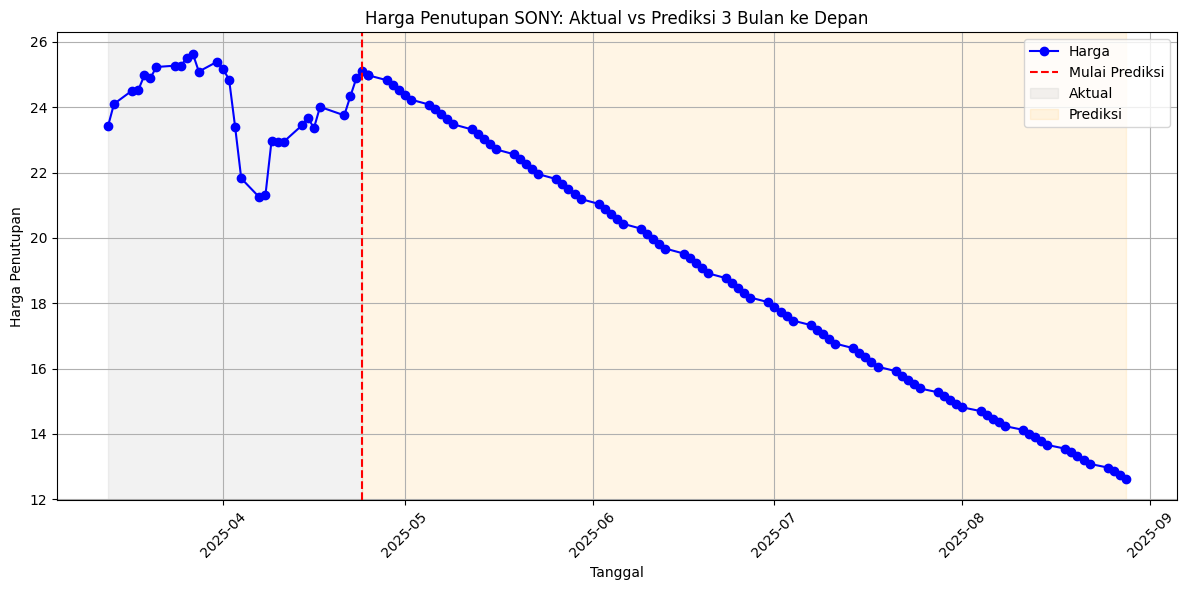

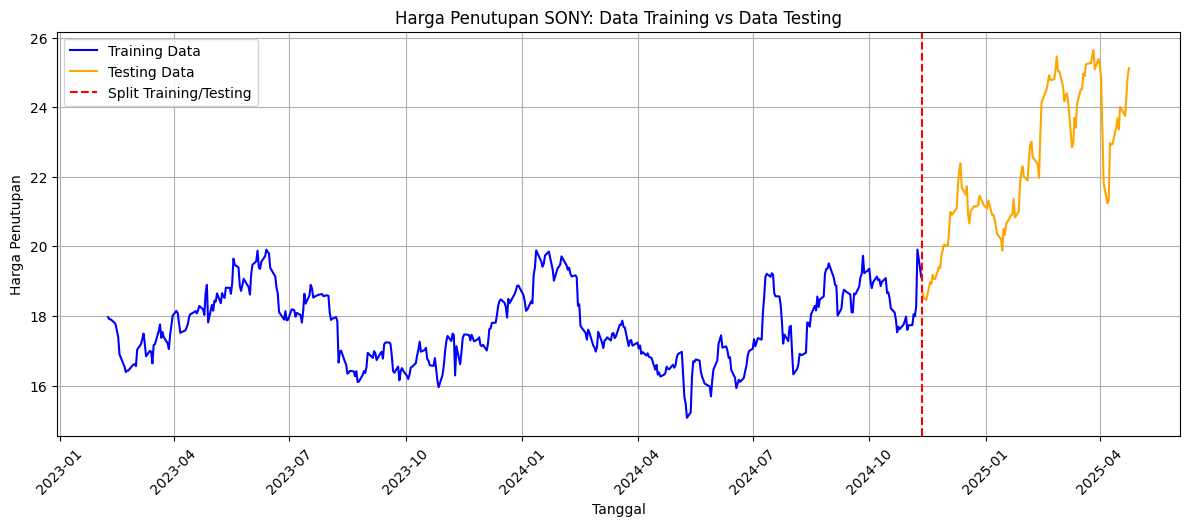


================= MEMPROSES 1810.HK =================


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


MAE   : 0.4608
MSE   : 1.1459
RMSE  : 1.0705
R²    : 0.6169
Tanggal penutupan terakhir: 2025-04-24
Harga penutupan terakhir  : 48.20
Prediksi penutupan        : 47.72 (untuk tanggal 2025-04-25)

📈 Evaluasi Real (Auto Yahoo Finance):
Harga aktual         : 47.70
Selisih prediksi     : 0.02
MAPE terhadap aktual : 0.05%
Akurasi prediksi     : 99.95%



Prediksi 3 bulan ke depan:
Prediksi untuk tanggal 2025-04-25 : 47.72
Prediksi untuk tanggal 2025-04-25 : 47.72
Prediksi untuk tanggal 2025-04-28 : 47.26
Prediksi untuk tanggal 2025-04-29 : 46.79
Prediksi untuk tanggal 2025-04-30 : 46.33
Prediksi untuk tanggal 2025-05-01 : 45.87
Prediksi untuk tanggal 2025-05-02 : 45.42
Prediksi untuk tanggal 2025-05-05 : 44.96
Prediksi untuk tanggal 2025-05-06 : 44.50
Prediksi untuk tanggal 2025-05-07 : 44.04
Prediksi untuk tanggal 2025-05-08 : 43.59
Prediksi untuk tanggal 2025-05-09 : 43.13
Prediksi untuk tanggal 2025-05-12 : 42.67
Prediksi untuk tanggal 2025-05-13 : 42.22
Prediksi untuk tanggal 2025-05-14 : 41.76
Prediksi untuk tanggal 2025-05-15 : 41.30
Prediksi untuk tanggal 2025-05-16 : 40.85
Prediksi untuk tanggal 2025-05-19 : 40.39
Prediksi untuk tanggal 2025-05-20 : 39.93
Prediksi untuk tanggal 2025-05-21 : 39.48
Prediksi untuk tanggal 2025-05-22 : 39.02
Prediksi untuk tanggal 2025-05-23 : 38.56
Prediksi untuk tanggal 2025-05-26 : 38.11
Predik

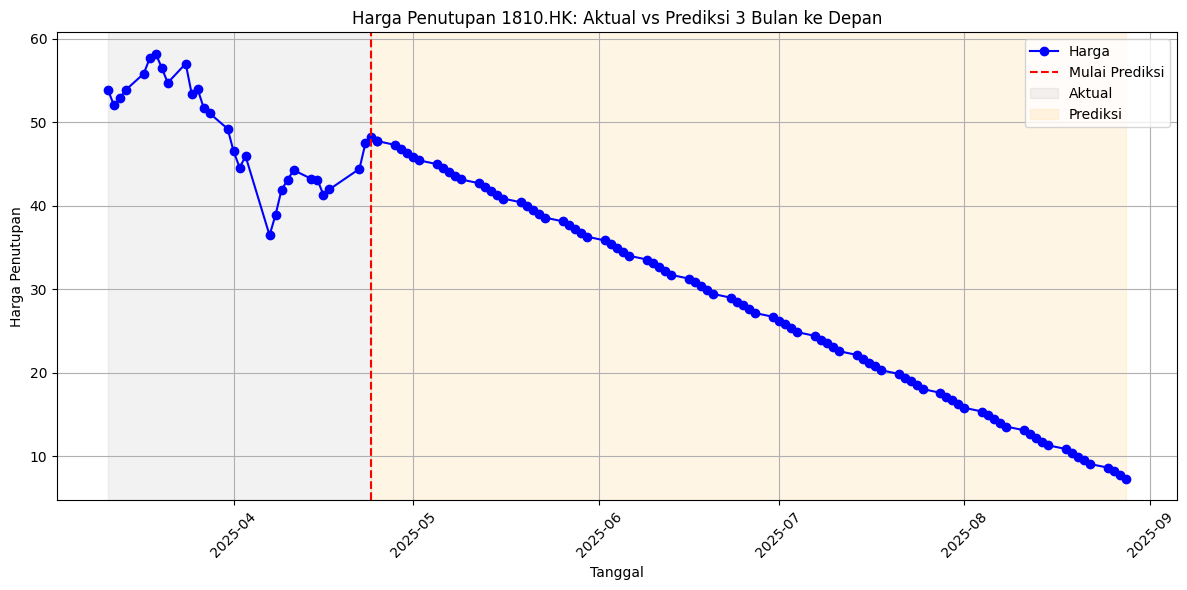

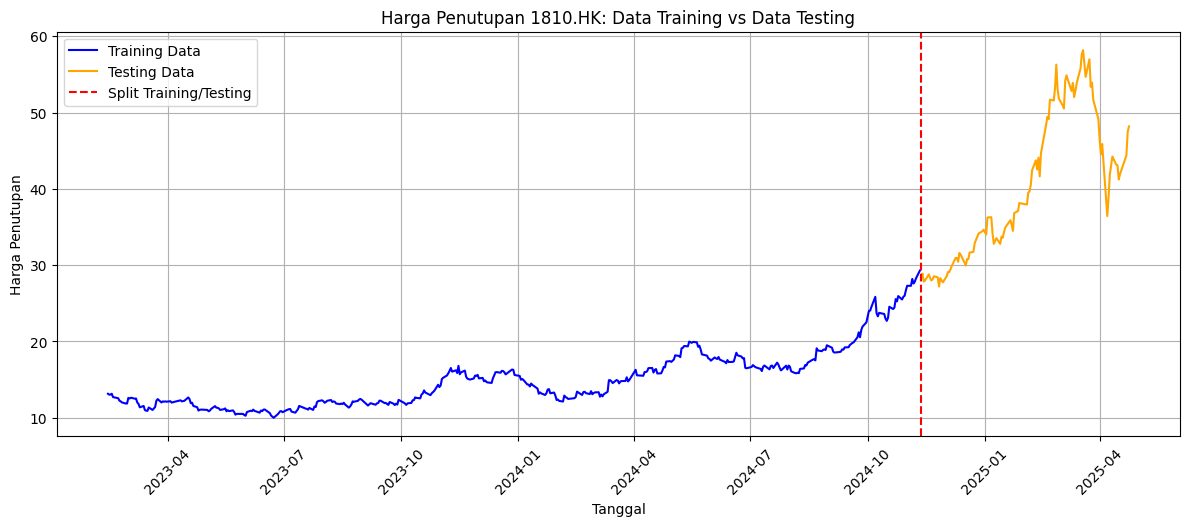


✅ Semua hasil prediksi disimpan ke: prediksi_3bulan_Sony&Xiaomi.csv

✅ Model global SONY_1810HK saham berhasil disimpan.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from datetime import datetime, timedelta
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from ta.momentum import RSIIndicator, ROCIndicator
from ta.trend import MACD, EMAIndicator, WMAIndicator
from ta.volatility import BollingerBands

tickers = ['SONY', '1810.HK']
sp500_ticker = '^GSPC'
start_date = '2023-01-01'
end_date = '2025-04-28'

# Membuat folder untuk menyimpan model
if not os.path.exists('models'):
    os.makedirs('models')

# Variabel untuk menyimpan model dan scaler dari ticker terakhir saja
last_model = None
last_scaler = None

prediksi_global = pd.DataFrame()

for ticker in tickers:
    print(f"\n================= MEMPROSES {ticker} =================")
    df = yf.download(ticker, start=start_date, end=end_date)
    sp500 = yf.download(sp500_ticker, start=start_date, end=end_date)

    if df.empty or len(df) < 100:
        print(f"{ticker} gagal: data terlalu sedikit")
        continue

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    sp500 = sp500[['Close']].rename(columns={'Close': 'SP500_Close'}).dropna()
    df = df.join(sp500, how='inner')

    # === FITUR TEKNIKAL & INTERAKSI ===
    df['Volume'] = np.log1p(df['Volume'])
    df['Lag1'] = df['Close'].shift(1)
    df['MA5'] = df['Close'].rolling(5).mean()
    df['MA10'] = df['Close'].rolling(10).mean()
    df['EMA10'] = EMAIndicator(close=df['Close'].squeeze(), window=10).ema_indicator()
    df['RSI'] = RSIIndicator(close=df['Close'].squeeze(), window=14).rsi()
    df['MACD'] = MACD(close=df['Close'].squeeze()).macd()
    df['BB_high'] = BollingerBands(close=df['Close'].squeeze()).bollinger_hband()
    df['BB_low'] = BollingerBands(close=df['Close'].squeeze()).bollinger_lband()
    df['Return'] = df['Close'].pct_change()
    df['RollingReturn5'] = df['Return'].rolling(5).mean()
    df['RollingReturn10'] = df['Return'].rolling(10).mean()
    df['Volatility5'] = df['Close'].pct_change().rolling(5).std()
    df['Price_Level'] = pd.qcut(df['Close'].iloc[:, 0] if isinstance(df['Close'], pd.DataFrame) else df['Close'], q=4, labels=False)

    df['Target'] = df['Close'].shift(-1) - df['Close']
    df.dropna(inplace=True)

    features = [col for col in df.columns if col not in ['Target', 'Close']]
    X = df[features]
    y = df['Target']

    features_path = "models/features_global.pkl"
    if not os.path.exists(features_path):
      joblib.dump(list(features), features_path)
      print(f" Fitur global disimpan: {features_path}")

    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {
        'n_estimators': [300],
        'learning_rate': [0.01],
        'max_depth': [4],
        'subsample': [0.8],
        'colsample_bytree': [0.9]
    }

    model = XGBRegressor(random_state=42)
    tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=0)
    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_
    best_model.fit(X_train_scaled, y_train)

    y_pred = best_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    last_date = df.index[-1]
    last_close = df['Close'].iloc[-1].item()
    last_input = X.iloc[[-1]]
    last_scaled = scaler.transform(last_input)
    predicted_delta = best_model.predict(last_scaled)[0]
    final_pred = last_close + predicted_delta

    next_date = last_date + timedelta(days=1)
    while next_date.weekday() >= 5:
        next_date += timedelta(days=1)

    print(f"\nMAE   : {mae:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print(f"R²    : {r2:.4f}")
    print(f"Tanggal penutupan terakhir: {last_date.strftime('%Y-%m-%d')}")
    print(f"Harga penutupan terakhir  : {last_close:.2f}")
    print(f"Prediksi penutupan        : {final_pred:.2f} (untuk tanggal {next_date.strftime('%Y-%m-%d')})")

    actual_data = yf.download(ticker, start=next_date.strftime('%Y-%m-%d'), end=(next_date + timedelta(days=1)).strftime('%Y-%m-%d'))
    if not actual_data.empty:
        harga_aktual_besok = actual_data['Close'].iloc[0].item()
        selisih = abs(final_pred - harga_aktual_besok)
        mape_real = (selisih / harga_aktual_besok) * 100
        akurasi_real = 100 - mape_real
        print("\n📈 Evaluasi Real (Auto Yahoo Finance):")
        print(f"Harga aktual         : {harga_aktual_besok:.2f}")
        print(f"Selisih prediksi     : {selisih:.2f}")
        print(f"MAPE terhadap aktual : {mape_real:.2f}%")
        print(f"Akurasi prediksi     : {akurasi_real:.2f}%")

    # Simpan model & scaler terakhir
    last_model = best_model
    last_scaler = scaler

    future_dates = []
    future_predictions = []

    # Tambahkan prediksi besok ke future_predictions dan future_dates
    future_predictions.append(final_pred)
    future_dates.append(next_date)

    # === PREDIKSI 3 BULAN KE DEPAN ===
    n_future = 90
    # future_dates = []
    # future_predictions = []

    # Tambahkan prediksi besok KE LOOP pertama
    next_date = last_date + timedelta(days=1)
    while next_date.weekday() >= 5:
        next_date += timedelta(days=1)

    last_known_close = last_close
    last_known_input = last_input.copy()

    for i in range(n_future):
        scaled_input = scaler.transform(last_known_input)
        predicted_delta = best_model.predict(scaled_input)[0]
        predicted_price = last_known_close + predicted_delta

        future_predictions.append(predicted_price)
        future_dates.append(next_date)

        next_date += timedelta(days=1)
        while next_date.weekday() >= 5:
            next_date += timedelta(days=1)

        new_row = last_known_input.copy()
        new_row['Lag1'] = predicted_price
        close_series = df['Close'].values.flatten().tolist() + future_predictions[:i+1]

        new_row['MA5'] = np.mean(close_series[-5:]) if len(close_series) >= 5 else np.nan
        new_row['MA10'] = np.mean(close_series[-10:]) if len(close_series) >= 10 else np.nan
        new_row['EMA10'] = EMAIndicator(pd.Series(close_series)).ema_indicator().iloc[-1]
        new_row['RSI'] = RSIIndicator(pd.Series(close_series)).rsi().iloc[-1]
        new_row['MACD'] = MACD(pd.Series(close_series)).macd().iloc[-1]
        new_row['BB_high'] = BollingerBands(pd.Series(close_series)).bollinger_hband().iloc[-1]
        new_row['BB_low'] = BollingerBands(pd.Series(close_series)).bollinger_lband().iloc[-1]
        new_row['Return'] = (predicted_price - last_known_close) / last_known_close
        new_row['RollingReturn5'] = pd.Series(close_series).pct_change().rolling(5).mean().iloc[-1]
        new_row['RollingReturn10'] = pd.Series(close_series).pct_change().rolling(10).mean().iloc[-1]
        new_row['Volatility5'] = pd.Series(close_series).pct_change().rolling(5).std().iloc[-1]
        new_row['Price_Level'] = pd.qcut(pd.Series(close_series), q=4, labels=False).iloc[-1]

        last_known_input = new_row
        last_known_close = predicted_price

    print("\nPrediksi 3 bulan ke depan:")
    for d, p in zip(future_dates, future_predictions):
        print(f"Prediksi untuk tanggal {d.strftime('%Y-%m-%d')} : {p:.2f}")

    # --- Tambahkan ke DataFrame global ---
    df_pred_ticker = pd.DataFrame({
        'Tanggal Prediksi': future_dates,
         ticker: [round(p, 2) for p in future_predictions]
    })

    global prediksi_global
    if prediksi_global.empty:
        prediksi_global = df_pred_ticker
    else:
        prediksi_global = pd.merge(prediksi_global, df_pred_ticker, on='Tanggal Prediksi', how='outer')

    # === EVALUASI HISTORIS TERHADAP 90 Data TERAKHIR (VALIDASI MODEL) ===
    X_val = X_test_scaled[-90:]
    y_val = y_test[-90:]
    y_pred_val = best_model.predict(X_val)

    mae_val = mean_absolute_error(y_val, y_pred_val)
    mse_val = mean_squared_error(y_val, y_pred_val)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(y_val, y_pred_val)

    print("\n=== Evaluasi Model Terhadap 3 Bulan Terakhir (Validasi Historis) ===")
    print(f"MAE   : {mae_val:.4f}")
    print(f"MSE   : {mse_val:.4f}")
    print(f"RMSE  : {rmse_val:.4f}")
    print(f"R²    : {r2_val:.4f}")

    # === GRAFIK PREDIKSI ===
    last_n = 30
    df_plot = df.tail(30).copy()
    df_plot_dates = df_plot.index.tolist()

    extended_dates = df_plot_dates + future_dates
    extended_prices = df_plot['Close'].values.flatten().tolist() + future_predictions

    plt.figure(figsize=(12, 6))
    plt.plot(extended_dates, extended_prices, label='Harga', color='blue', marker='o')
    plt.axvline(x=df_plot_dates[-1], color='red', linestyle='--', label='Mulai Prediksi')
    plt.axvspan(df_plot_dates[0], df_plot_dates[-1], color='grey', alpha=0.1, label='Aktual')
    plt.axvspan(df_plot_dates[-1], extended_dates[-1], color='orange', alpha=0.1, label='Prediksi')
    plt.title(f'Harga Penutupan {ticker}: Aktual vs Prediksi 3 Bulan ke Depan')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Plot Split Training/Testing ---
    # Tentukan proporsi split (80% training, 20% testing)
    train_size = 0.8
    split_index = int(len(df) * train_size)

    # Bagi data
    train_data = df.iloc[:split_index]
    test_data = df.iloc[split_index:]

    # Plot Data
    plt.figure(figsize=(12, 5))
    plt.plot(train_data.index, train_data['Close'], label='Training Data', color='blue')
    plt.plot(test_data.index, test_data['Close'], label='Testing Data', color='orange')

    # Garis vertikal sebagai pemisah
    plt.axvline(x=df.index[split_index], color='red', linestyle='--', label='Split Training/Testing')

    # Format akhir plot
    plt.title(f'Harga Penutupan {ticker}: Data Training vs Data Testing')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

# Simpan hasil prediksi
csv_all_filename = f'prediksi_3bulan_Sony&Xiaomi.csv'
prediksi_global.to_csv(csv_all_filename, index=False)
print(f"\n✅ Semua hasil prediksi disimpan ke: {csv_all_filename}")

# Simpan model terakhir
tickers_nama = '_'.join([t.replace('.', '') for t in tickers])
joblib.dump(last_model, f"models/model_xgb_global_{tickers_nama}.pkl")
joblib.dump(last_scaler, f"models/scaler_global_{tickers_nama}.pkl")
print(f"\n✅ Model global {tickers_nama} saham berhasil disimpan.")

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import joblib
from ta.momentum import RSIIndicator
from ta.trend import MACD, EMAIndicator
from ta.volatility import BollingerBands
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

# Load model dan scaler
model = joblib.load('models/model_xgb_global_SONY_1810HK.pkl')
scaler = joblib.load('models/scaler_global_SONY_1810HK.pkl')

# Daftar saham
tickers = ['SONY', '1810.HK']
sp500_ticker = '^GSPC'

# Rentang data
start_date = '2023-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# DataFrame untuk hasil prediksi 1 hari & 3 bulan
hasil_besok = []
prediksi_3bulan = pd.DataFrame()

for ticker in tickers:
    print(f"\n====== MEMPROSES {ticker} ======")

    # Download data saham dan SP500
    df = yf.download(ticker, start=start_date, end=end_date)
    sp500 = yf.download(sp500_ticker, start=start_date, end=end_date)

    if df.empty or len(df) < 100:
        print(f"{ticker} gagal: data terlalu sedikit")
        continue

    # Preprocessing
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    sp500 = sp500[['Close']].rename(columns={'Close': 'SP500_Close'}).dropna()
    df = df.join(sp500, how='inner')

    df['Volume'] = np.log1p(df['Volume'])
    df['Lag1'] = df['Close'].shift(1)
    df['MA5'] = df['Close'].rolling(5).mean()
    df['MA10'] = df['Close'].rolling(10).mean()
    df['EMA10'] = EMAIndicator(close=df['Close'].squeeze(), window=10).ema_indicator()
    df['EMA20'] = EMAIndicator(close=df['Close'].squeeze(), window=20).ema_indicator()
    df['EMA50'] = EMAIndicator(close=df['Close'].squeeze(), window=50).ema_indicator()
    df['RSI'] = RSIIndicator(close=df['Close'].squeeze(), window=14).rsi()
    df['MACD'] = MACD(close=df['Close'].squeeze()).macd()
    df['BB_high'] = BollingerBands(close=df['Close'].squeeze()).bollinger_hband()
    df['BB_low'] = BollingerBands(close=df['Close'].squeeze()).bollinger_lband()
    df['Return'] = df['Close'].pct_change()
    df['RollingReturn5'] = df['Return'].rolling(5).mean()
    df['RollingReturn10'] = df['Return'].rolling(10).mean()
    df['Volatility5'] = df['Close'].pct_change().rolling(5).std()
    df['Price_Level'] = pd.qcut(df['Close'].squeeze(), q=4, labels=False)

    df.dropna(inplace=True)

    # Fitur dan target
    features = [col for col in df.columns if col != 'Close']
    X = df[features]

    # Prediksi harga besok
    X_new = df.iloc[[-1]].drop('Close', axis=1)
    X_new_scaled = scaler.transform(X_new)

    predicted_delta = model.predict(X_new_scaled)[0]
    last_close = df['Close'].iloc[-1].item()
    predicted_close_besok = last_close + predicted_delta

    print(f"Harga penutupan terakhir: {last_close:.2f}")
    print(f"Prediksi harga esok hari: {predicted_close_besok:.2f}")

    hasil_besok.append({
        'Ticker': ticker,
        'Last_Close': round(last_close, 2),
        'Predicted_Close_Tomorrow': round(predicted_close_besok, 2)
    })

    # Prediksi 90 hari ke depan
    n_future = 90
    future_dates = []
    future_prices = []

    last_known_close = last_close
    last_known_input = X_new.copy()

    next_date = df.index[-1]

    for i in range(n_future):
        scaled_input = scaler.transform(last_known_input)
        predicted_delta = model.predict(scaled_input)[0]
        predicted_price = last_known_close + predicted_delta

        # Geser tanggal ke hari bursa berikutnya
        next_date += timedelta(days=1)
        while next_date.weekday() >= 5:
            next_date += timedelta(days=1)
        future_dates.append(next_date.strftime('%Y-%m-%d'))
        future_prices.append(predicted_price)

        # Update fitur untuk hari berikutnya
        new_row = last_known_input.copy()
        new_row['Lag1'] = predicted_price
        close_series = df['Close'].squeeze().tolist() + future_prices[:i+1]

        new_row['MA5'] = np.mean(close_series[-5:]) if len(close_series) >= 5 else np.nan
        new_row['MA10'] = np.mean(close_series[-10:]) if len(close_series) >= 10 else np.nan
        new_row['EMA10'] = EMAIndicator(pd.Series(close_series)).ema_indicator().iloc[-1]
        new_row['EMA20'] = EMAIndicator(pd.Series(close_series)).ema_indicator().iloc[-1]
        new_row['EMA50'] = EMAIndicator(pd.Series(close_series)).ema_indicator().iloc[-1]
        new_row['RSI'] = RSIIndicator(pd.Series(close_series)).rsi().iloc[-1]
        new_row['MACD'] = MACD(pd.Series(close_series)).macd().iloc[-1]
        new_row['BB_high'] = BollingerBands(pd.Series(close_series)).bollinger_hband().iloc[-1]
        new_row['BB_low'] = BollingerBands(pd.Series(close_series)).bollinger_lband().iloc[-1]
        new_row['Return'] = (predicted_price - last_known_close) / last_known_close
        new_row['RollingReturn5'] = pd.Series(close_series).pct_change().rolling(5).mean().iloc[-1]
        new_row['RollingReturn10'] = pd.Series(close_series).pct_change().rolling(10).mean().iloc[-1]
        new_row['Volatility5'] = pd.Series(close_series).pct_change().rolling(5).std().iloc[-1]
        new_row['Price_Level'] = pd.qcut(pd.Series(close_series), q=4, labels=False).iloc[-1]
        new_row['SP500_Close'] = sp500['SP500_Close'].iloc[-1]  # SP500 tetap gunakan nilai terakhir

        last_known_input = new_row
        last_known_close = predicted_price

    # Masukkan prediksi 3 bulan ke tabel
    df_future = pd.DataFrame({
        'Tanggal Prediksi': future_dates,
        ticker: [round(p, 2) for p in future_prices]
    })
    if prediksi_3bulan.empty:
        prediksi_3bulan = df_future
    else:
        prediksi_3bulan = pd.merge(prediksi_3bulan, df_future, on='Tanggal Prediksi', how='outer')

# === Setelah semua saham diproses ===

# Simpan hasil prediksi besok
today = datetime.today().strftime('%Y%m%d')
df_besok = pd.DataFrame(hasil_besok)
df_besok.to_csv(f'hasil_prediksi_besok_{today}.csv', index=False)
print(f"\n✅ Hasil prediksi besok disimpan ke: hasil_prediksi_besok_{today}.csv")

# Simpan hasil prediksi 3 bulan
prediksi_3bulan.to_csv(f'hasil_prediksi_3bulan_{today}.csv', index=False)
print(f"✅ Hasil prediksi 3 bulan disimpan ke: hasil_prediksi_3bulan_{today}.csv")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


====== MEMPROSES SONY ======
Harga penutupan terakhir: 24.97
Prediksi harga esok hari: 26.14



<ipython-input-9-079a4dc60fe6>:68: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_new = df.iloc[[-1]].drop('Close', axis=1)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


====== MEMPROSES 1810.HK ======
Harga penutupan terakhir: 47.70
Prediksi harga esok hari: 48.88



<ipython-input-9-079a4dc60fe6>:68: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_new = df.iloc[[-1]].drop('Close', axis=1)



✅ Hasil prediksi besok disimpan ke: hasil_prediksi_besok_20250428.csv
✅ Hasil prediksi 3 bulan disimpan ke: hasil_prediksi_3bulan_20250428.csv
